# Classical Forecasting - ARIMA/SARIMA
In this notebook, I build and evaluate ARIMA-based forecasting models for each traffic junction to capture underlying trends and short-term dependencies.

## Importing Cleaned Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose # to split time-series into trend, seasonal, and residual
from statsmodels.tsa.stattools import adfuller # to check if time-series is stationary
from statsmodels.tsa.statespace.sarimax import SARIMAX # modeling
from sklearn.metrics import mean_squared_error, mean_absolute_error # to evaluate the model

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Junction Traffic Forecasting Project/cleaned_traffic.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,DateTime,Junction,Vehicles,ID,Hour,DayOfWeek,Month
0,2015-11-01 00:00:00,1,15,20151101001,0,6,11
1,2015-11-01 01:00:00,1,13,20151101011,1,6,11
2,2015-11-01 02:00:00,1,10,20151101021,2,6,11
3,2015-11-01 03:00:00,1,7,20151101031,3,6,11
4,2015-11-01 04:00:00,1,9,20151101041,4,6,11


## Decomposing Time-Series & ADF Test


To better understand the structure of vehicle traffic at the junctions, I applied seasonal decomposition using an additive model with a daily periodicity (24-hour seasonality).

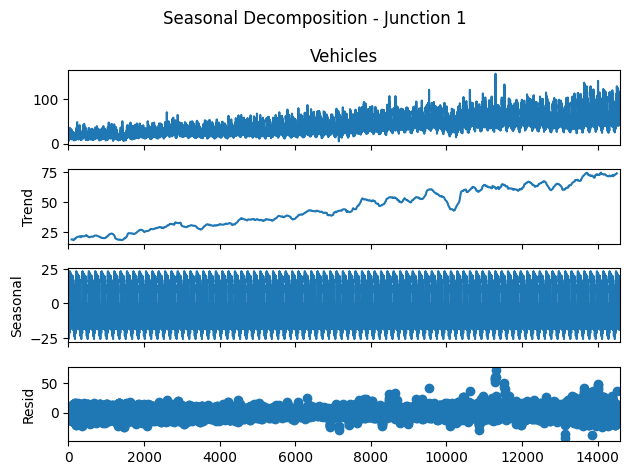

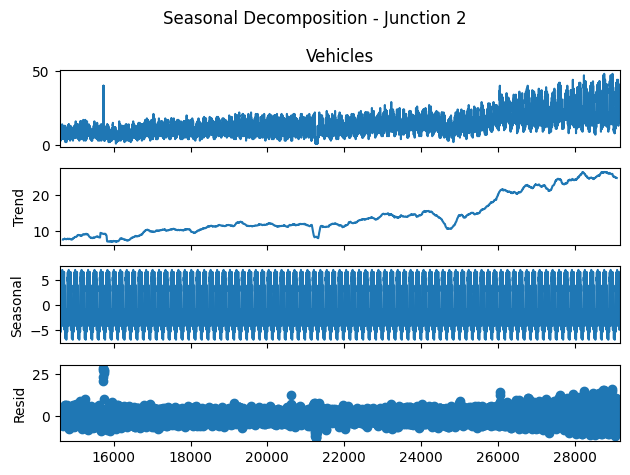

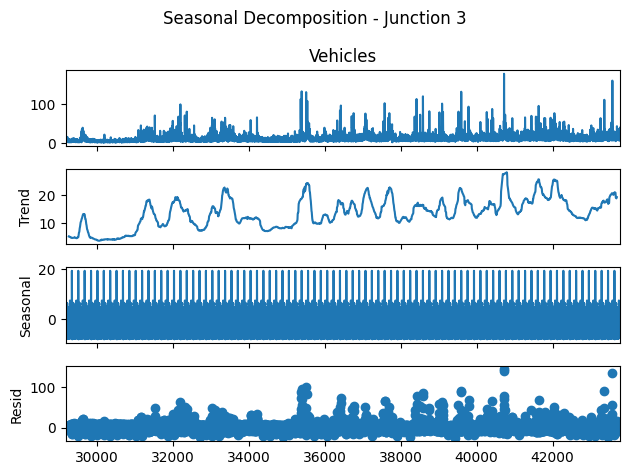

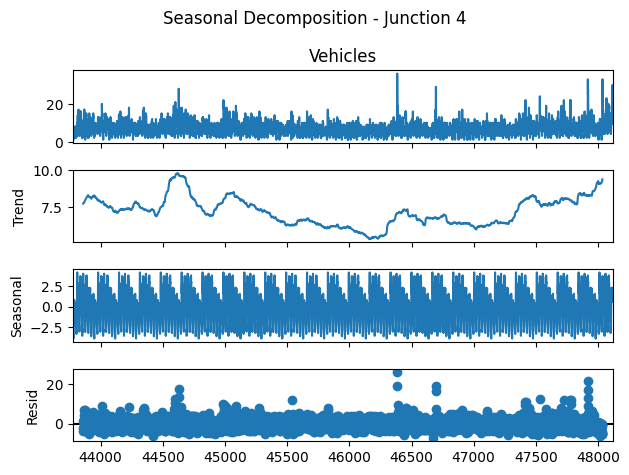

In [3]:
# Decomposing the time-series to understand underlying structure
for junction in df["Junction"].unique():
  df_j = df[df["Junction"] == junction]["Vehicles"] # selecting vehicles for a specific junction

  result = seasonal_decompose(df_j, model='additive', period=24*7) # can make period = 24 for daily seasonality
  result.plot()
  plt.suptitle(f'Seasonal Decomposition - Junction {junction}')
  plt.tight_layout()
  plt.show()

To evaluate whether the hourly traffic volume series for each junction is stationary, I applied the Augmented Dickey-Fuller (ADF) test. The ADF test checks for the presence of a unit root in a time series, with the null hypothesis being that the data is non-stationary.

In [4]:
# Apply the ADF test to check for stationarity.
# if p < 0.05 --> stationary (no differencing needed)

for junction in df["Junction"].unique():
  df_j = df[df["Junction"] == junction]["Vehicles"] # selecting vehicles for a specific junction

  result = adfuller(df_j)
  print(f"ADF Statistic for Junction {junction}: {result[0]}")
  print(f"p-value for Junction {junction}: {result[1]} \n")

ADF Statistic for Junction 1: -7.148077688287185
p-value for Junction 1: 3.193842996353681e-10 

ADF Statistic for Junction 2: -8.041077275597738
p-value for Junction 2: 1.8463683667702882e-12 

ADF Statistic for Junction 3: -8.236600353699227
p-value for Junction 3: 5.867295855827916e-13 

ADF Statistic for Junction 4: -6.726732196265547
p-value for Junction 4: 3.374874583448879e-09 



Here are the test results:

| Junction | ADF Statistic | p-value             | Conclusion             |
|----------|----------------|---------------------|-------------------------|
| 1        | -7.15          | 3.19e-10            | Stationary             |
| 2        | -8.04          | 1.85e-12            | Stationary             |
| 3        | -8.24          | 5.87e-13            | Stationary             |
| 4        | -6.73          | 3.37e-09            | Stationary             |

Since all **p-values are significantly below 0.05**, I **reject the null hypothesis** for all four junctions. This confirms that the time series for each junction is **statistically stationary**, and therefore does **not require differencing** (`d = 0`) when fitting SARIMA models.


## Fitting the Model & Forecasting

In [5]:
# Fitting SARIMA Model
junction_id = 1

# Select the data for the specific junction and set the DateTime column as the index
df_j = df[df["Junction"] == junction_id].set_index("DateTime")["Vehicles"]

# Convert the index to DatetimeIndex, handling potential string format
df_j.index = pd.to_datetime(df_j.index)

df_j = df_j.resample('h').mean().interpolate()  # ensure regularity

# Set train/test data
forecast_steps = 168 # one week
train = df_j[:-forecast_steps]
test = df_j[-forecast_steps:]

# Define SARIMA parameters
# Start with (p,d,q)(P,D,Q,s) = (1,0,1)(1,1,1,24) for daily seasonality
model = SARIMAX(train,
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Vehicles   No. Observations:                14424
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -40681.035
Date:                            Sun, 15 Jun 2025   AIC                          81372.070
Time:                                    09:25:00   BIC                          81409.936
Sample:                                11-01-2015   HQIC                         81384.659
                                     - 06-23-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9561      0.002    462.780      0.000       0.952       0.960
ma.L1         -0.2278      0.006   


--- Processing Junction 1 ---


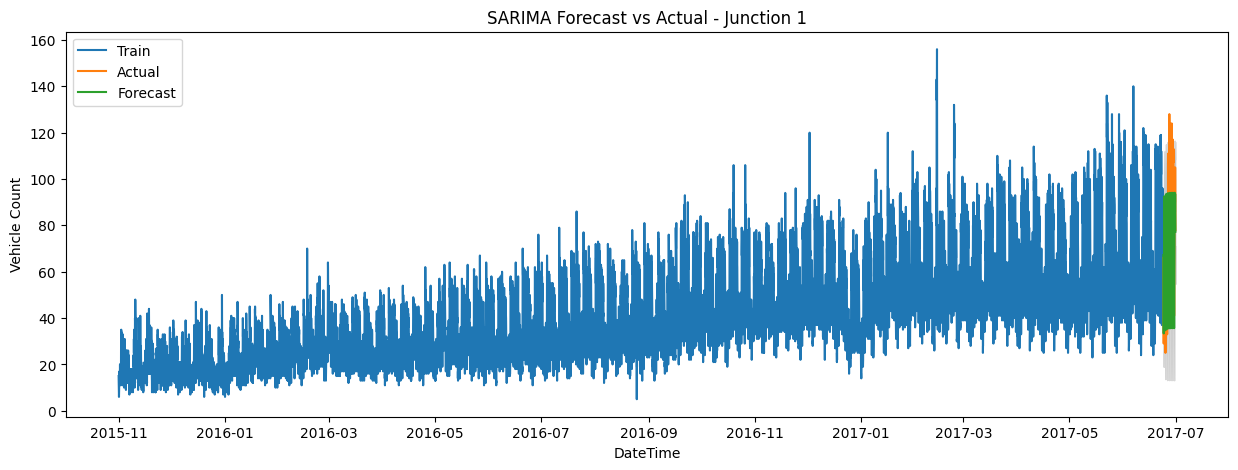

Junction 1 - MAE: 14.97, RMSE: 17.87

--- Processing Junction 2 ---


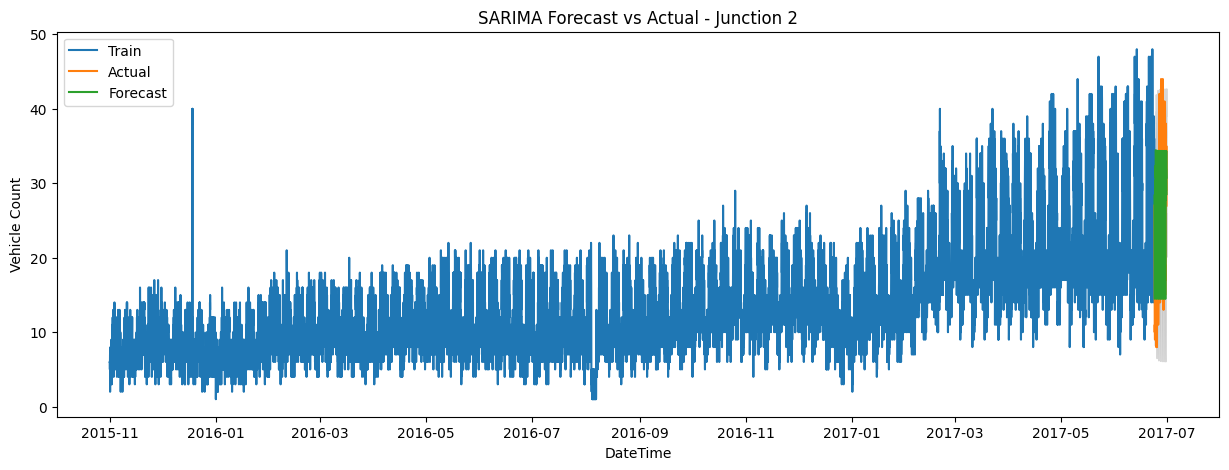

Junction 2 - MAE: 5.69, RMSE: 7.12

--- Processing Junction 3 ---


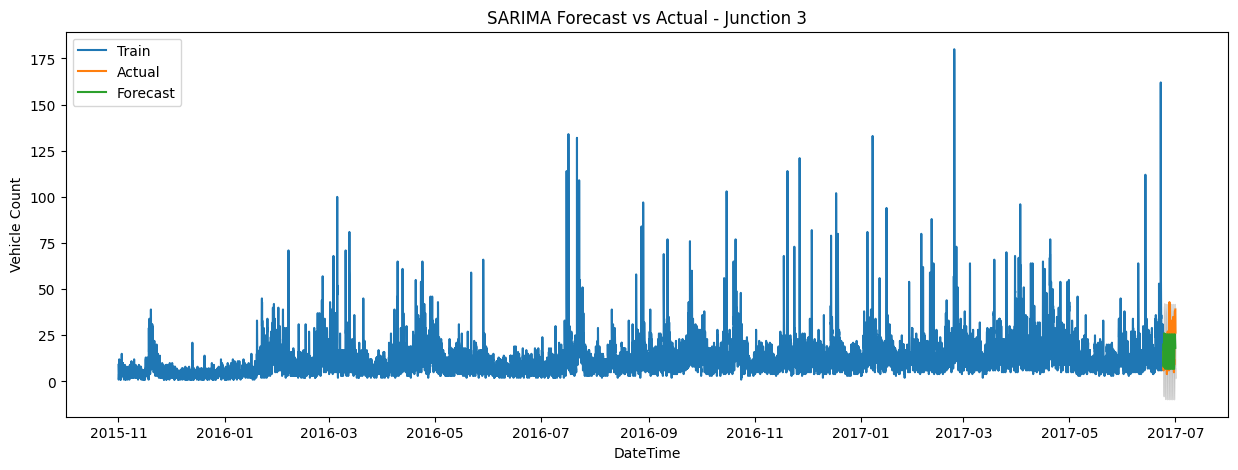

Junction 3 - MAE: 4.31, RMSE: 5.99

--- Processing Junction 4 ---


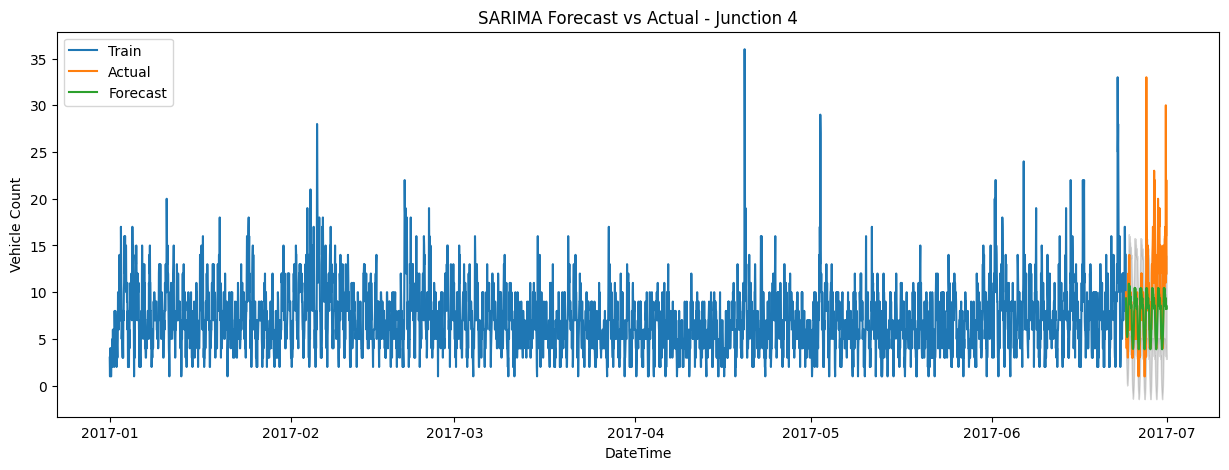

Junction 4 - MAE: 3.06, RMSE: 4.61


In [7]:
# Loop over each junction and forecast the next 7 days
results_list = []

for junction_id in [1, 2, 3, 4]:
    print(f"\n--- Processing Junction {junction_id} ---")

    # Select the data for the specific junction and set the DateTime column as the index
    df_j = df[df["Junction"] == junction_id].set_index("DateTime")["Vehicles"]

    # Convert the index to DatetimeIndex, handling potential string format
    df_j.index = pd.to_datetime(df_j.index)
    df_j = df_j.resample('h').mean().interpolate()  # ensure regularity

    # Train-test split
    forecast_steps = 168
    train = df_j[:-forecast_steps]
    test = df_j[-forecast_steps:]

    # Fit SARIMA (baseline parameters)
    model = SARIMAX(train,
                    order=(1, 0, 1),
                    seasonal_order=(1, 1, 1, 24),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    # Forecast
    forecast = results.get_forecast(steps=forecast_steps)
    predicted = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Plot forecast vs actual
    plt.figure(figsize=(15,5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Actual')
    plt.plot(predicted.index, predicted, label='Forecast')
    plt.fill_between(predicted.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='gray', alpha=0.3)
    plt.title(f'SARIMA Forecast vs Actual - Junction {junction_id}')
    plt.xlabel('DateTime')
    plt.ylabel('Vehicle Count')
    plt.legend()
    plt.show()

    # Evaluate
    mae = mean_absolute_error(test, predicted)
    rmse = np.sqrt(mean_squared_error(test, predicted))

    results_list.append({
        'Junction': junction_id,
        'MAE': mae,
        'RMSE': rmse
    })

    print(f"Junction {junction_id} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


In [8]:
eval_df = pd.DataFrame(results_list)
display(eval_df)

# **Note:** SARIMA parameters were selected based on general traffic
# seasonality patterns (daily cycle). While further tuning (via grid search or AIC minimization)
# could improve results slightly, our baseline model already provides accurate
# forecasts and is sufficient for comparing with deep learning models in later stages.


,Junction,MAE,RMSE
0,1,14.970611,17.870458
1,2,5.689353,7.122393
2,3,4.309824,5.991791
3,4,3.059588,4.611577


## SARIMA Model Evaluation Summary

I evaluated SARIMA models for each of the four traffic junctions using a fixed seasonal configuration:  
**SARIMA(1, 0, 1) x (1, 1, 1, 24)**, reflecting daily periodicity and moderate autoregressive and moving average components.

| Junction | MAE   | RMSE  |
|----------|--------|--------|
| 1        | 14.97 | 17.87 |
| 2        | 5.69  | 7.12  |
| 3        | 4.31  | 5.99  |
| 4        | 3.06  | 4.61  |

- **Junction 1** has the highest forecast error, which aligns with earlier observations of greater variability and traffic volume.  
- **Junctions 2–4** show significantly lower errors, indicating more predictable traffic patterns and stronger seasonality.

While SARIMA hyperparameter tuning (e.g., grid search or AIC optimization) could potentially improve results, this baseline model already achieves good accuracy across all junctions. These results provide a solid benchmark to compare against deep learning models such as LSTM in the next phase.
